Source of data\
<https://www.bea.gov/news/2020/gross-domestic-product-state-4th-quarter-and-annual-2019>\
<https://www.bea.gov/news/2016/gross-domestic-product-state-4th-quarter-and-annual-2015>\
<http://beagov.prod.acquia-sites.com/sites/default/files/newsreleases/regional/gdp_state/2012/xls/gsp0612.xls>\

In [1]:
import pandas as pd
import numpy as np

#stuff for plotting states
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
import missingno as msno
import os
import openpyxl
import math

In [2]:
df = pd.read_excel('../data/gdp/2011.xls')
df = df[~df.iloc[:, 0].isna()]
df.iloc[:, 0] = df.iloc[:, 0].replace(to_replace=r'\.', value='', regex=True)
df.iloc[:, 0] = df.iloc[:, 0].replace(r'United States/1/', 'United States', regex=True)
df = df.iloc[:-3, [0, 4]]

df.columns = ['Region', '2011']
df.index = np.arange(1, len(df) + 1)
df.head()

,Region,2011
1,United States,13108674
2,New England,717865
3,Connecticut,201386
4,Maine,44821
5,Massachusetts,348577


In [3]:
df2 = pd.read_excel('../data/gdp/2015.xlsx', sheet_name='Table 3')
df2 = df2[~df2.iloc[:, 0].isna()]
df2 = df2[['Unnamed: 5']]
df2.columns = ['2015']
df2.index = np.arange(1, len(df2) + 1)
df = pd.concat([df, df2], axis=1)
df.head()

,Region,2011,2015
1,United States,13108674,18047289
2,New England,717865,962825
3,Connecticut,201386,260643
4,Maine,44821,57621
5,Massachusetts,348577,481630


In [4]:
df3 = pd.read_excel('../data/gdp/2019.xlsx', sheet_name='Table 3')
df3 = df3[~df3.iloc[:, 0].isna()]
df3 = df3[['Unnamed: 8']]
df3.columns = ['2019']
df3.index = np.arange(1, len(df3) + 1)
df = pd.concat([df, df3], axis=1)
df.head()

,Region,2011,2015,2019
1,United States,13108674,18047289,21729124
2,New England,717865,962825,1151182
3,Connecticut,201386,260643,288985
4,Maine,44821,57621,68441
5,Massachusetts,348577,481630,604208


In [5]:
gdf = gpd.read_file('../data/state_shape')
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [6]:
def makeColorColumn(gdf,variable,vmin,vmax,colormap):
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

def gen_map(year_selection, gdf, remove_powerhouse):
    colormap=plt.cm.viridis
    year_df = df[['Region', year_selection]].copy()
    year_df['Region'] = year_df['Region'].str.strip()
    if (remove_powerhouse):
        year_df.loc[year_df['Region'] == 'California', :] = '---'
        year_df.loc[year_df['Region'] == 'Texas', :] = '---'
        year_df.loc[year_df['Region'] == 'New York', :] = '---'
        year_df.loc[year_df['Region'] == 'Florida', :] = '---'
        year_df.loc[year_df['Region'] == 'Illinois', :] = '---'
        year_df.loc[year_df['Region'] == 'Pennsylvania', :] = '---'
    year_df['Region'] = year_df['Region'].str.strip()
    year_df[year_selection] = pd.to_numeric(year_df[year_selection], errors='coerce')
    gdf = gdf.merge(year_df,left_on='NAME',right_on='Region')
    vmin, vmax = gdf[year_selection].min(), gdf[year_selection].max()
    gdf = makeColorColumn(gdf,year_selection,vmin,vmax,colormap)
    
    visframe = gdf.to_crs('EPSG:2163')
    
    fig, ax = plt.subplots(1, figsize=(18, 14))
    ax.set_title('GDP by States ' + year_selection, fontdict={'fontsize': '42', 'fontweight' : '1'})
    if(remove_powerhouse):
        ax.set_title('GDP by States without powerhouses ' + year_selection, fontdict={'fontsize': '42', 'fontweight' : '1'})
    ax.axis('off')
    
    fig = ax.get_figure() 
    
    for row in visframe.itertuples():
        if row.STUSPS not in ['AK','HI']:
            vf = visframe[visframe.STUSPS==row.STUSPS]
            c = gdf[gdf.STUSPS==row.STUSPS][0:1].value_determined_color.item()
            vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='1')
    
    # add Alaska
    akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
    akax.axis('off')
    polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
    alaska_gdf = gdf[gdf.STUSPS=='AK']
    alaska_gdf.clip(polygon).plot(color=gdf[gdf.STUSPS=='AK'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='1')
    
    
    # add Hawaii
    hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
    hiax.axis('off')
    hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
    hawaii_gdf = gdf[gdf.STUSPS=='HI']
    hawaii_gdf.clip(hipolygon).plot(color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='1')
    
    fig = ax.get_figure()
    cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31]) 
    cbax.set_title('Relative to the highest GDP of that year.')
    sm = plt.cm.ScalarMappable(cmap=colormap, \
                     norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    comma_fmt = FuncFormatter(lambda x, p: format(x/vmax, '.0'))
    fig.colorbar(sm, cax=cbax, format=comma_fmt)
    tick_font_size = 16
    cbax.tick_params(labelsize=tick_font_size)

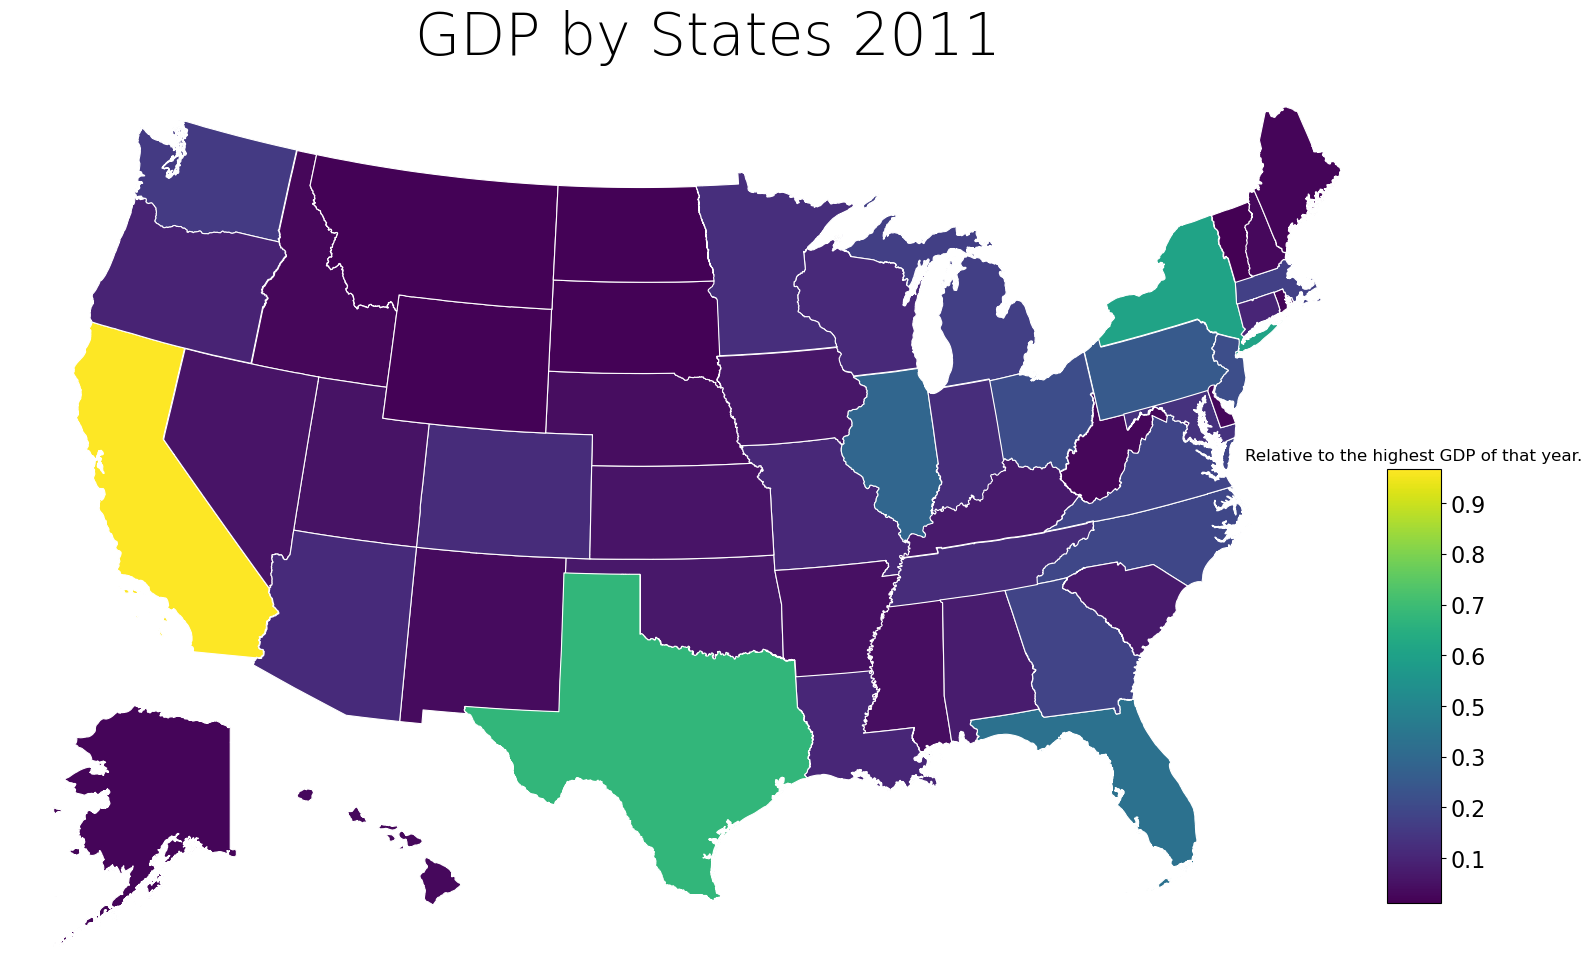

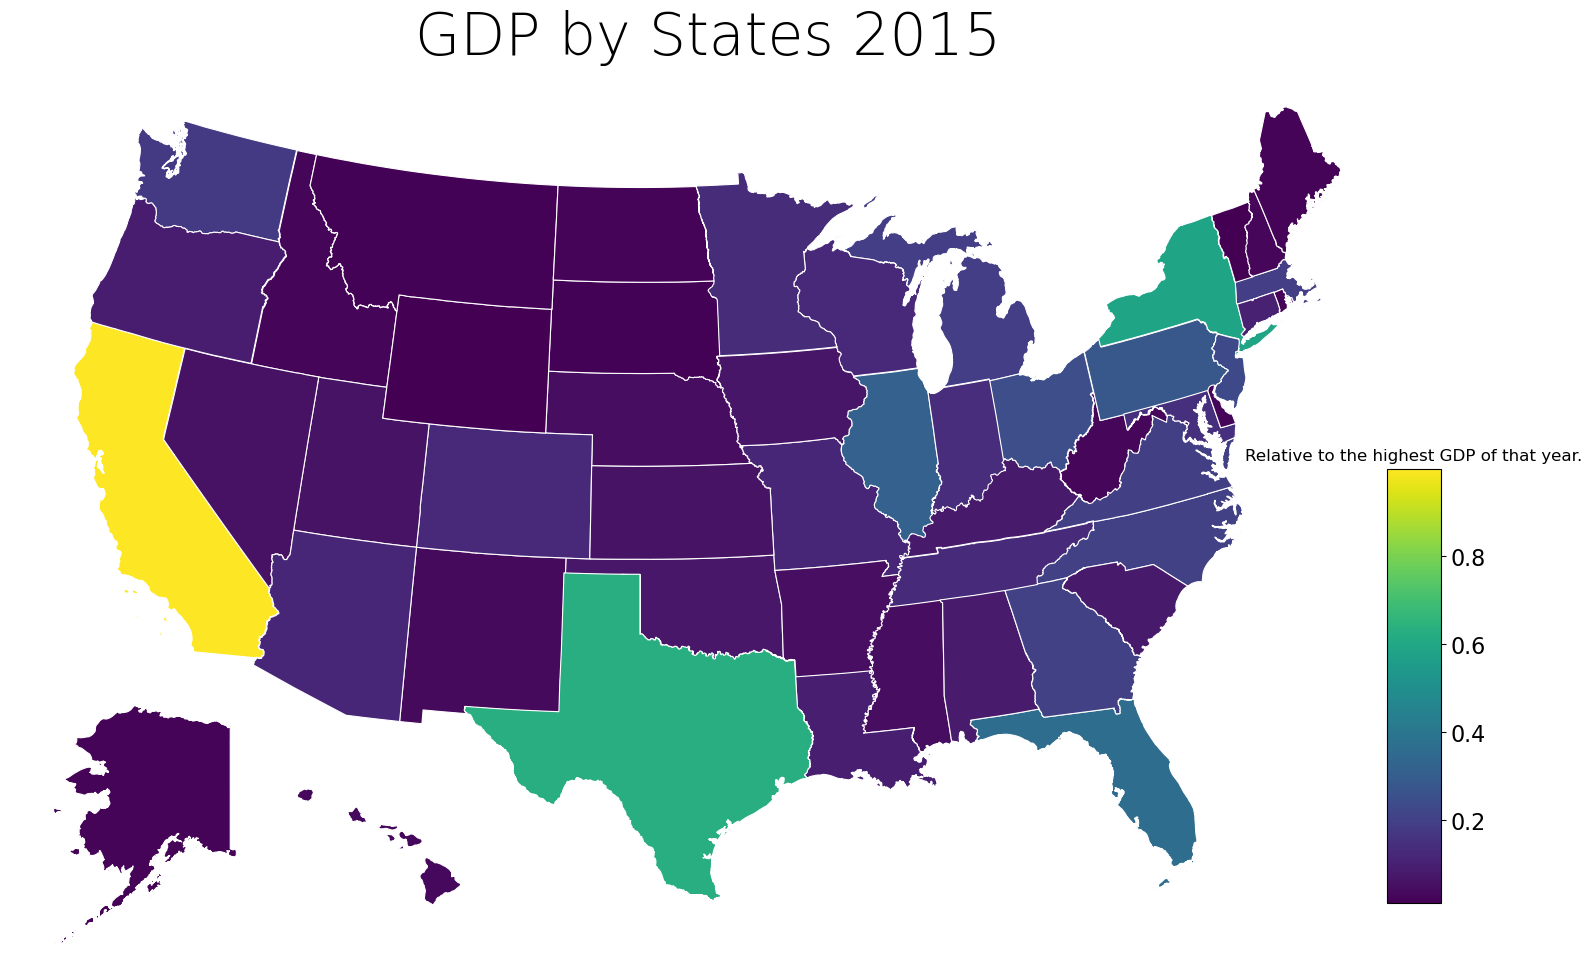

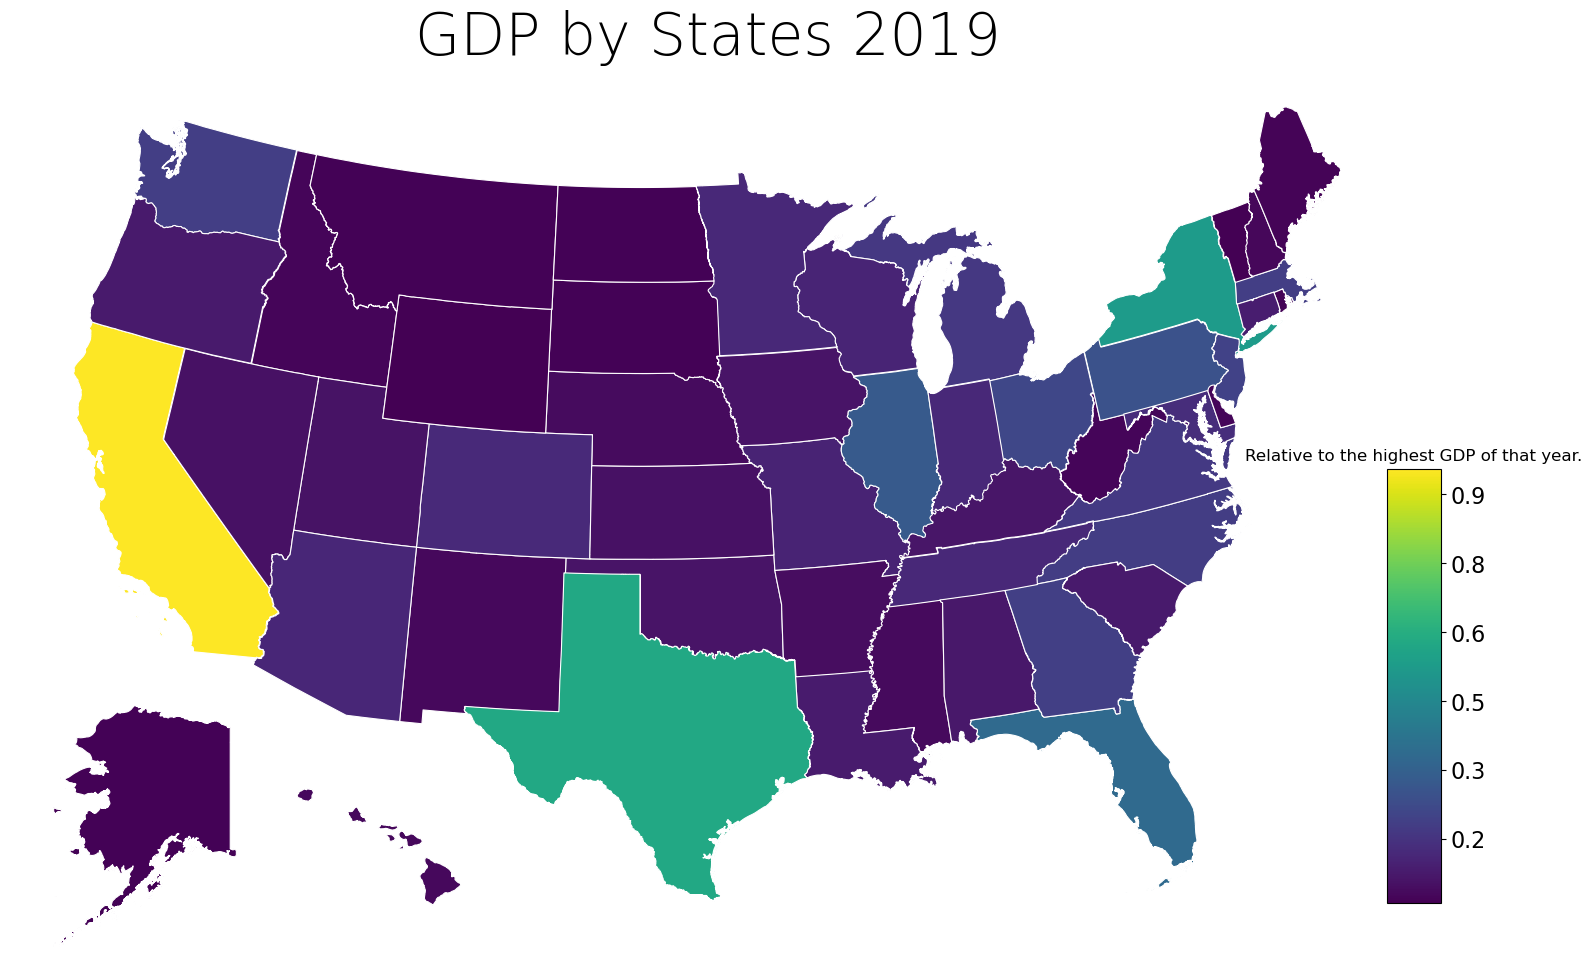

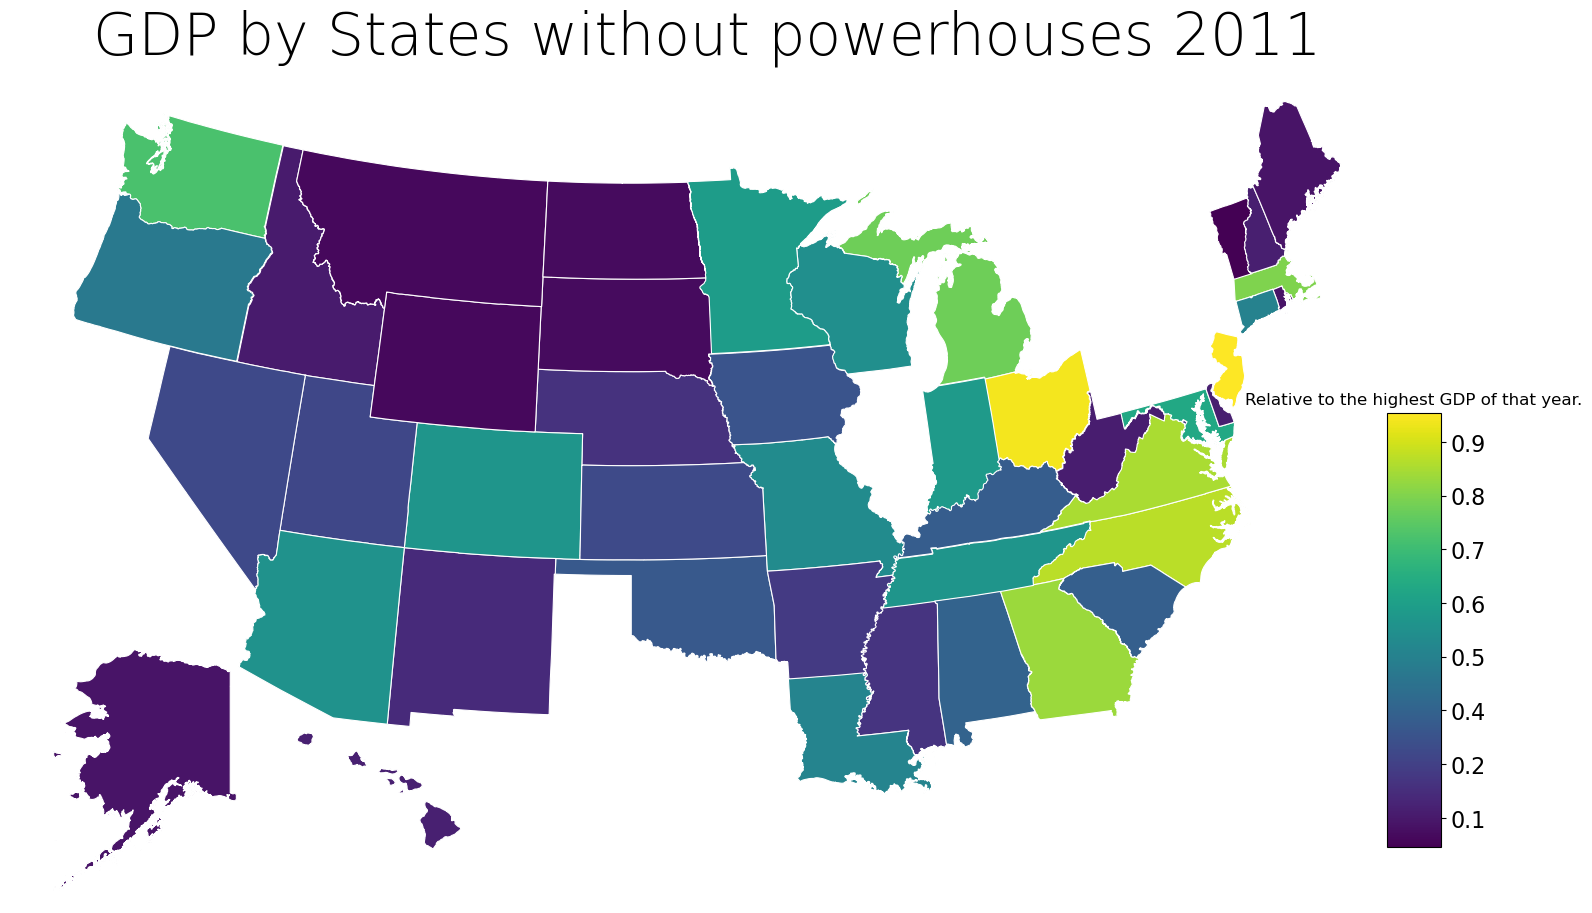

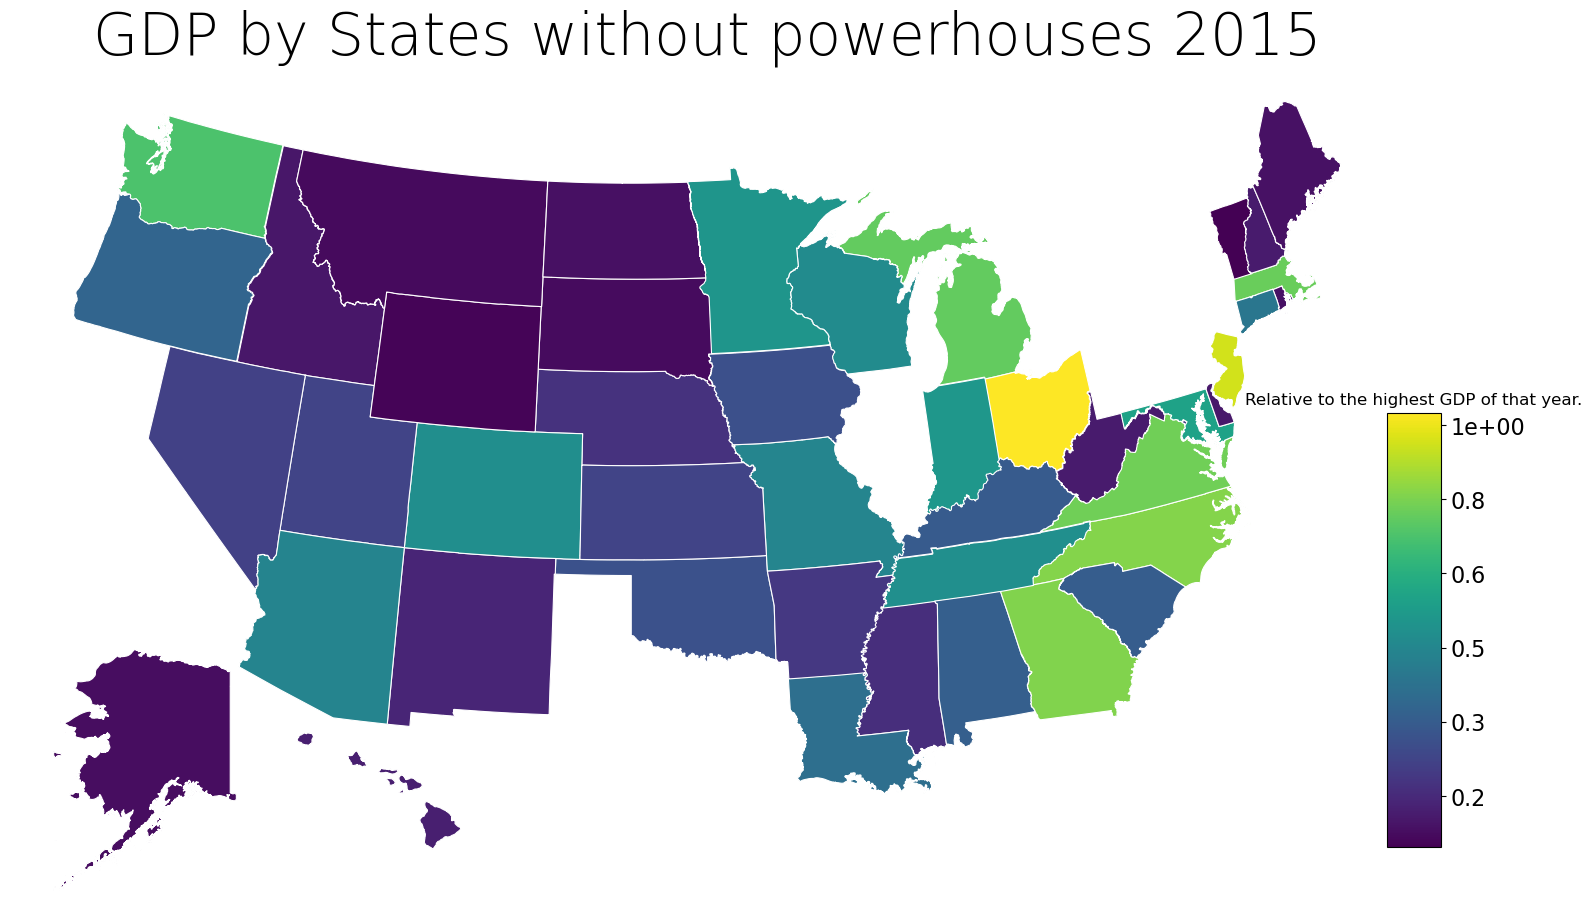

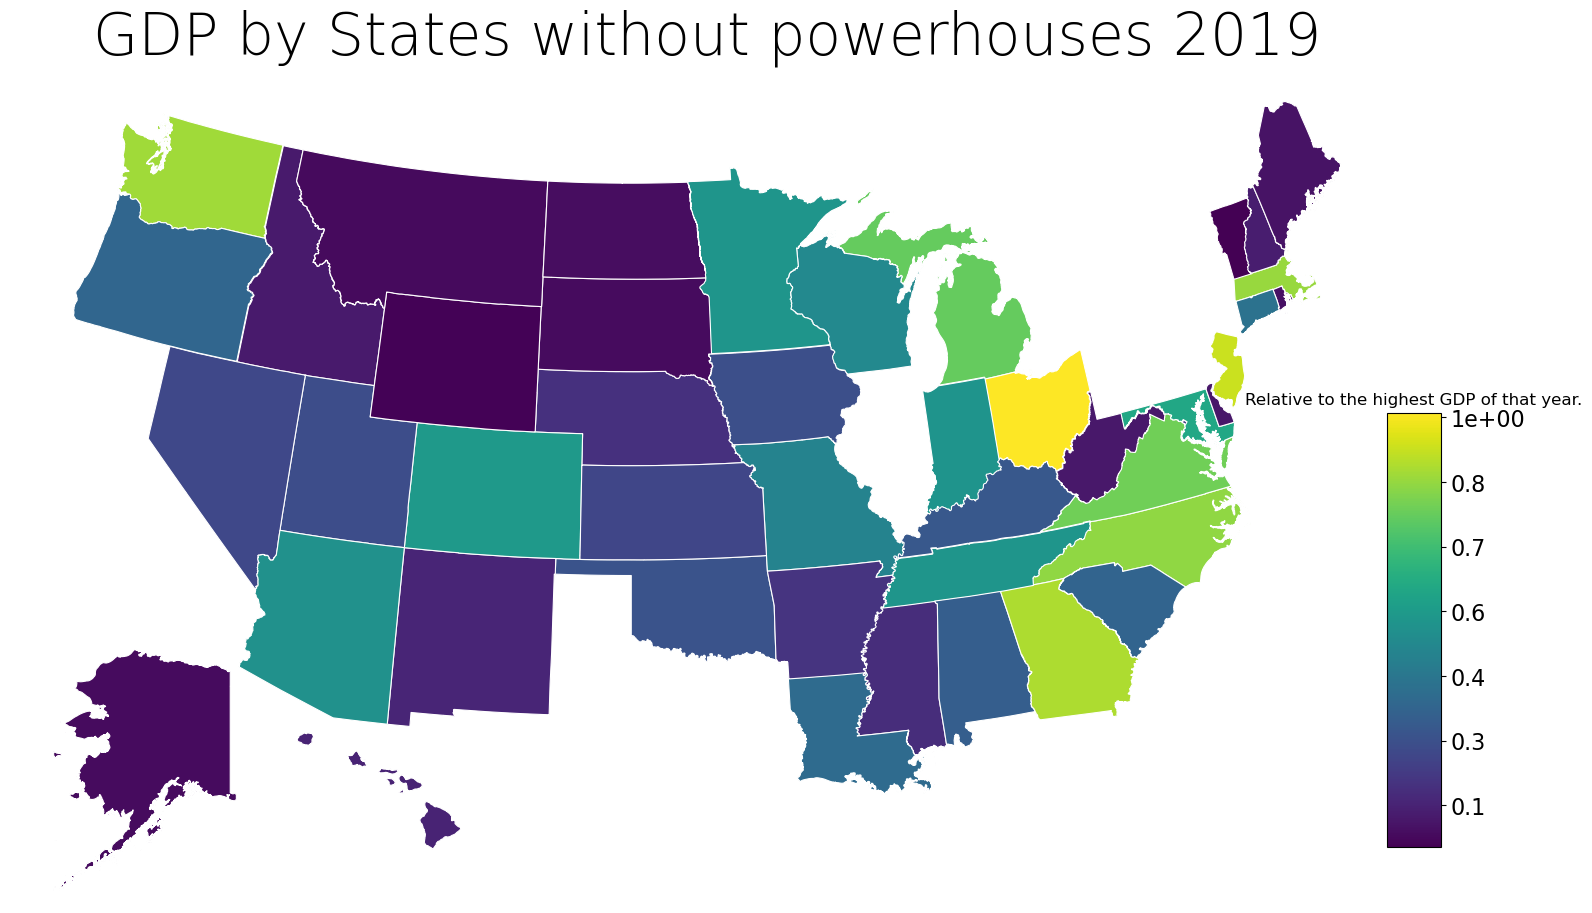

In [7]:
for flag in [0,1]:
    for year in ['2011', '2015', '2019']:
        gen_map(year,gdf,flag)
        if (flag):
            plt.savefig(os.path.join('../output/GDP',f'GDP in {year} without powerhouses'))
        else:
            plt.savefig(os.path.join('../output/GDP',f'GDP in {year}'))

In [8]:
df.columns = ['Region','GDP_2011','GDP_2015','GDP_2019']
df.to_csv(os.path.join('../output/GDP','table.csv'))

In [9]:
pred_df = pd.read_excel('../data/gdp/2024.xlsx')
pred_df = pred_df[~pred_df.iloc[:, 0].isna()]
df4 = pred_df[['Unnamed: 5']]
df4.columns = ['GDP_2024']
pred_df = pred_df[['Table 1. Gross Domestic Product by State and Region: Level and Percent Change From Preceding Period','Unnamed: 5']]
pred_df.columns = ['Region','2024']
pred_df.index = np.arange(1, len(pred_df) + 1)
pred_df.head()
df4.index = np.arange(1, len(df4) + 1)
df = pd.concat([df, df4], axis=1)
df.head()
pred_df.to_csv(os.path.join('../output/GDP','pred_table.csv'))

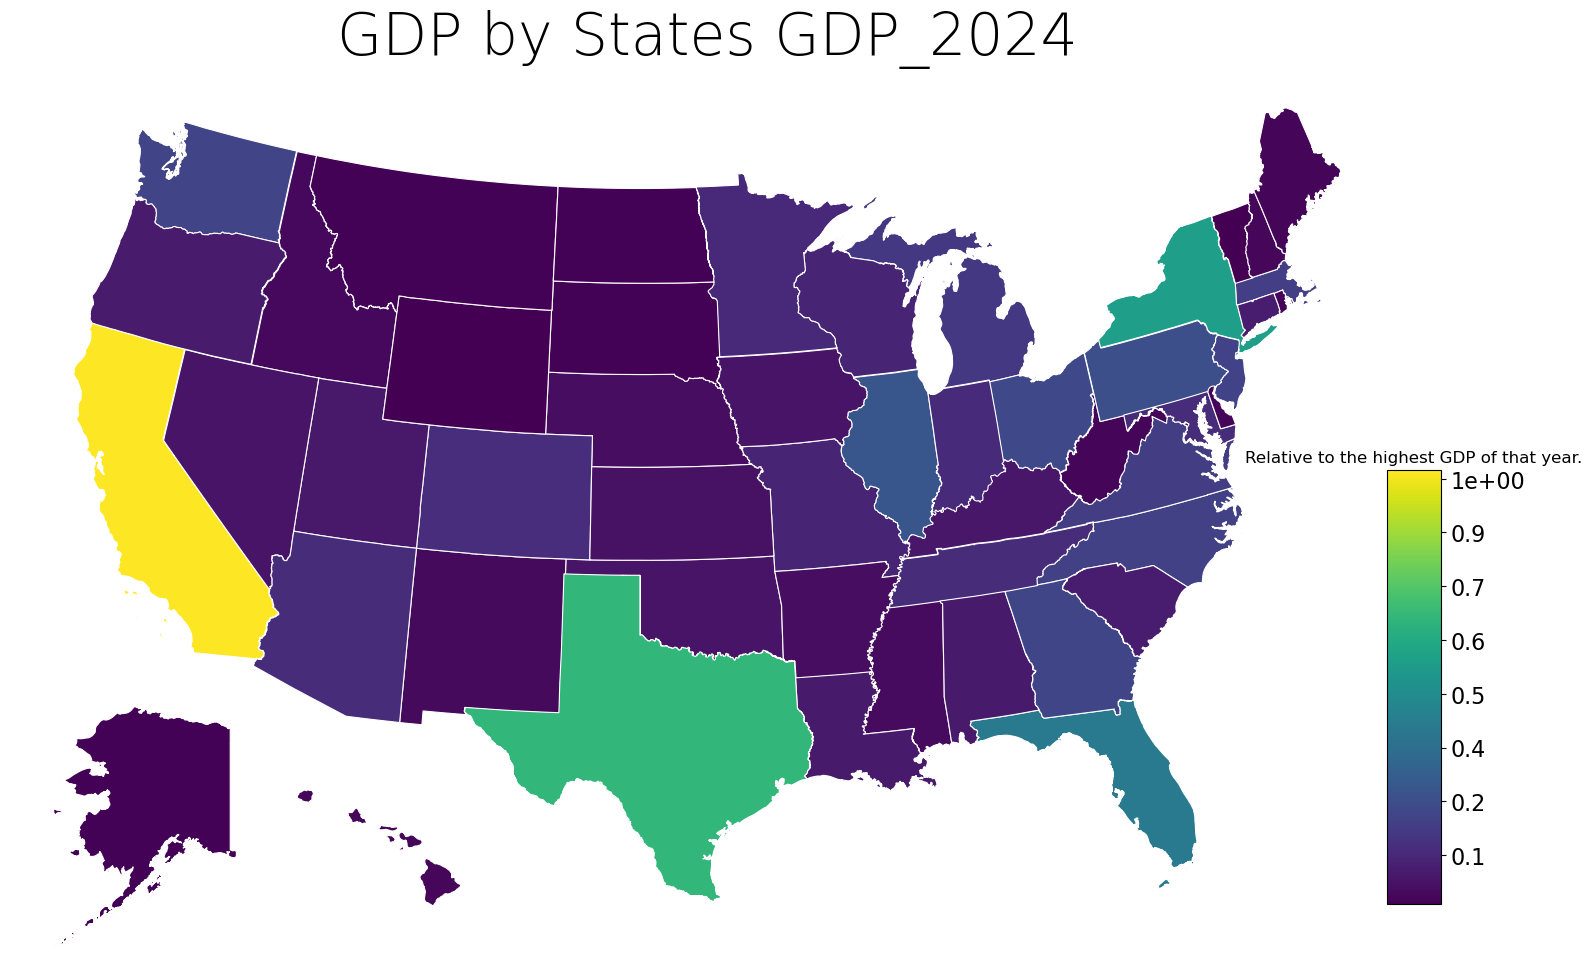

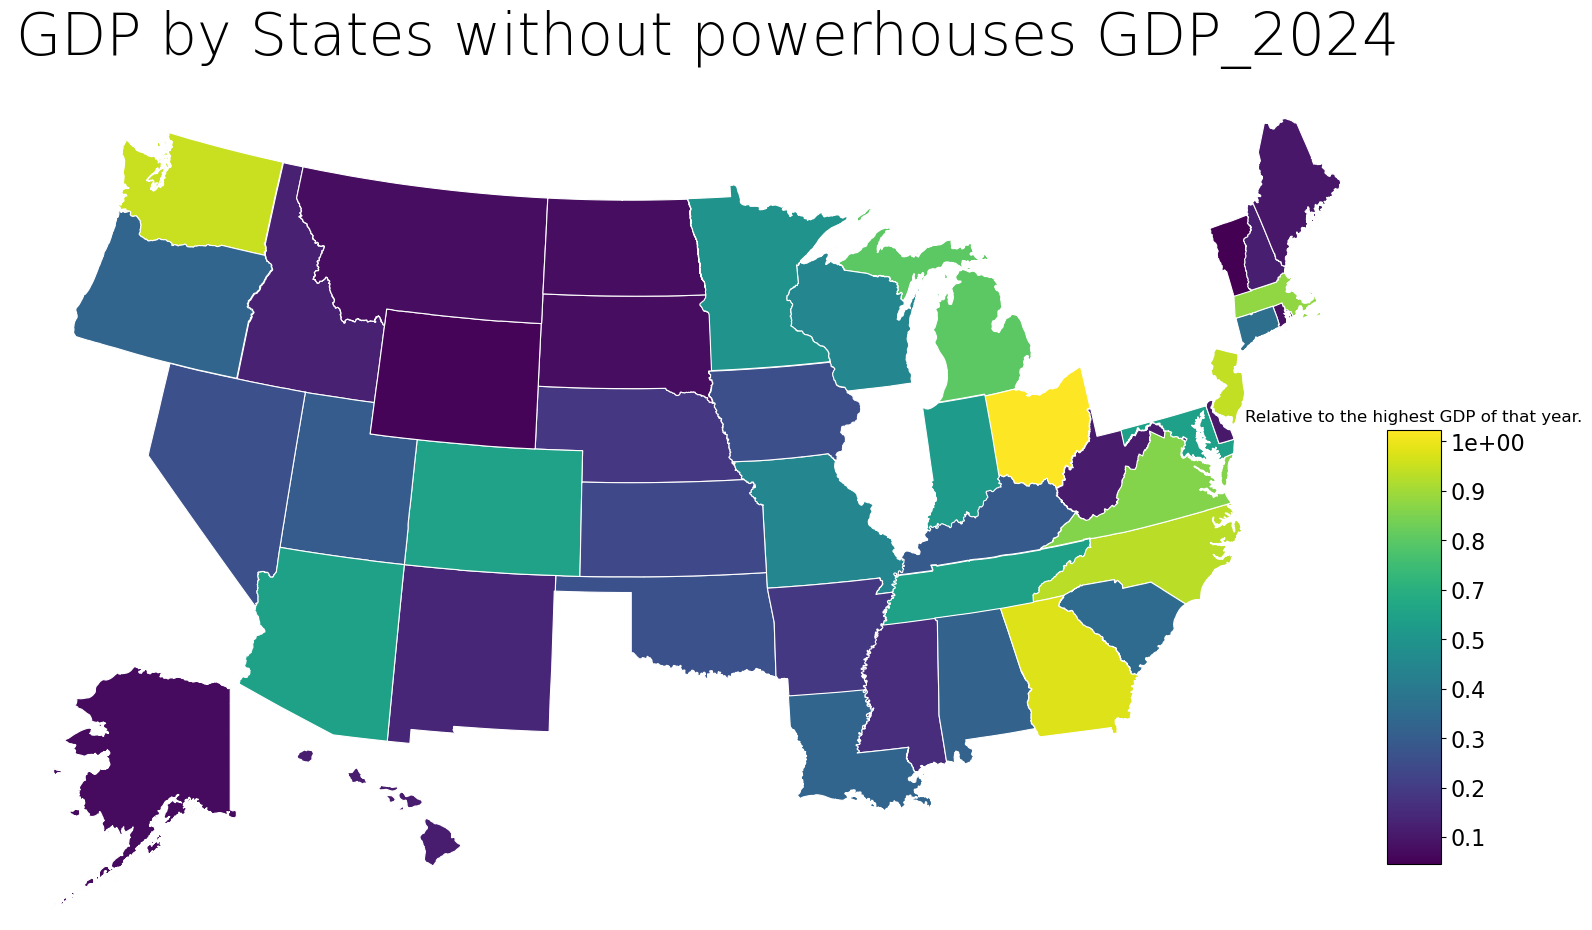

In [10]:
gen_map('GDP_2024',gdf,0)
plt.savefig(os.path.join('../output/GDP',f'GDP in 2024'))
gen_map('GDP_2024',gdf,1)
plt.savefig(os.path.join('../output/GDP',f'GDP in 2024 without powerhouses'))